##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CSV データを読み込む

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/csv">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/load_data/csv.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png"> ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、TensorFlow で CSV データを使用する方法の例を示します。

これには2つの主要な部分があります。

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

このチュートリアルでは、読み込みに焦点を当て、前処理の簡単な例をいくつか実演します。前処理レイヤーの使用方法の詳細については、[前処理レイヤーの使用](https://www.tensorflow.org/guide/keras/preprocessing_layers)ガイドと [Keras 前処理レイヤーを使用した構造化データの分類](../structured_data/preprocessing_layers.ipynb)チュートリアルを参照してください。


## MNIST モデルをビルドする

In [2]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

2022-12-15 01:04:36.061220: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 01:04:36.061327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 01:04:36.061337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## インメモリデータ

小さな CSV データセットの場合、TensorFlow モデルをトレーニングする最も簡単な方法は、pandas データフレームまたは NumPy 配列としてメモリを読み込むことです。


比較的単純な例は、[アワビデータセット](https://archive.ics.uci.edu/ml/datasets/abalone)です。

- データセットが小さい。
- すべての入力特徴量は、制限された範囲の浮動小数点値です。

データを[ pandas `DataFrame` ](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)にダウンロードする方法は次のとおりです。

In [3]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   0.435     0.335   0.110         0.334          0.1355          0.0775   
1   0.585     0.450   0.125         0.874          0.3545          0.2075   
2   0.655     0.510   0.160         1.092          0.3960          0.2825   
3   0.545     0.425   0.125         0.768          0.2940          0.1495   
4   0.545     0.420   0.130         0.879          0.3740          0.1695   

   Shell weight  Age  
0        0.0965    7  
1        0.2250    6  
2        0.3700   14  
3        0.2600   16  
4        0.2300   13

データセットには、海のカタツムリの一種である[アワビ](https://en.wikipedia.org/wiki/Abalone)の一連の測定値が含まれています。

![an abalone shell](https://tensorflow.org/images/abalone_shell.jpg)

[「アワビ貝殻」](https://www.flickr.com/photos/thenickster/16641048623/) (作成者：[Nicki Dugan Pogue](https://www.flickr.com/photos/thenickster/)、CC BY-SA 2.0)


このデータセットの名目上のタスクは、他の測定値から年齢を予測することなので、トレーニング用に特徴とラベルを分離します。


In [4]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')

このデータセットでは、すべての特徴を同じように扱います。特徴を単一の NumPy アレイにパックします。

In [5]:
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435, 0.335, 0.11 , ..., 0.136, 0.077, 0.097],
       [0.585, 0.45 , 0.125, ..., 0.354, 0.207, 0.225],
       [0.655, 0.51 , 0.16 , ..., 0.396, 0.282, 0.37 ],
       ...,
       [0.53 , 0.42 , 0.13 , ..., 0.374, 0.167, 0.249],
       [0.395, 0.315, 0.105, ..., 0.118, 0.091, 0.119],
       [0.45 , 0.355, 0.12 , ..., 0.115, 0.067, 0.16 ]])

次に、回帰モデルで年齢を予測します。入力テンソルは 1 つしかないため、ここでは `keras.Sequential` モデルで十分です。

In [6]:
abalone_model = tf.keras.Sequential([
  layers.Dense(64),
  layers.Dense(1)
])

abalone_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())

モデルをトレーニングするには、特徴とラベルを`Model.fit`に渡します。

In [7]:
abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10


  1/104 [..............................] - ETA: 2:12 - loss: 103.3369

 24/104 [=====>........................] - ETA: 0s - loss: 105.9437  

 48/104 [============>.................] - ETA: 0s - loss: 95.8777 

 72/104 [===================>..........] - ETA: 0s - loss: 83.6569

 96/104 [==========================>...] - ETA: 0s - loss: 72.9668

104/104 [==============================] - 2s 2ms/step - loss: 69.3848


Epoch 2/10


  1/104 [..............................] - ETA: 0s - loss: 27.1454

 25/104 [======>.......................] - ETA: 0s - loss: 20.8976

 49/104 [=============>................] - ETA: 0s - loss: 17.1686

 73/104 [====================>.........] - ETA: 0s - loss: 14.9184

 98/104 [===========================>..] - ETA: 0s - loss: 13.4953

104/104 [==============================] - 0s 2ms/step - loss: 13.1364


Epoch 3/10


  1/104 [..............................] - ETA: 0s - loss: 10.7660

 26/104 [======>.......................] - ETA: 0s - loss: 9.5744 

 50/104 [=============>................] - ETA: 0s - loss: 8.7947

 74/104 [====================>.........] - ETA: 0s - loss: 8.5713

100/104 [===========================>..] - ETA: 0s - loss: 8.6108

104/104 [==============================] - 0s 2ms/step - loss: 8.5679


Epoch 4/10


  1/104 [..............................] - ETA: 0s - loss: 5.8775

 26/104 [======>.......................] - ETA: 0s - loss: 8.4001

 51/104 [=============>................] - ETA: 0s - loss: 8.2929

 77/104 [=====================>........] - ETA: 0s - loss: 8.3400

101/104 [============================>.] - ETA: 0s - loss: 8.2041

104/104 [==============================] - 0s 2ms/step - loss: 8.1167


Epoch 5/10


  1/104 [..............................] - ETA: 0s - loss: 5.2396

 26/104 [======>.......................] - ETA: 0s - loss: 8.3649

 50/104 [=============>................] - ETA: 0s - loss: 8.1693

 74/104 [====================>.........] - ETA: 0s - loss: 7.8922

 99/104 [===========================>..] - ETA: 0s - loss: 7.8061

104/104 [==============================] - 0s 2ms/step - loss: 7.7009


Epoch 6/10


  1/104 [..............................] - ETA: 0s - loss: 7.9681

 25/104 [======>.......................] - ETA: 0s - loss: 6.8068

 50/104 [=============>................] - ETA: 0s - loss: 6.6468

 74/104 [====================>.........] - ETA: 0s - loss: 6.9579

 99/104 [===========================>..] - ETA: 0s - loss: 7.3999

104/104 [==============================] - 0s 2ms/step - loss: 7.3671


Epoch 7/10


  1/104 [..............................] - ETA: 0s - loss: 10.9656

 26/104 [======>.......................] - ETA: 0s - loss: 8.1522 

 51/104 [=============>................] - ETA: 0s - loss: 7.6804

 76/104 [====================>.........] - ETA: 0s - loss: 7.3753

101/104 [============================>.] - ETA: 0s - loss: 7.1394

104/104 [==============================] - 0s 2ms/step - loss: 7.0970


Epoch 8/10


  1/104 [..............................] - ETA: 0s - loss: 4.9076

 26/104 [======>.......................] - ETA: 0s - loss: 7.3220

 51/104 [=============>................] - ETA: 0s - loss: 7.4048

 76/104 [====================>.........] - ETA: 0s - loss: 7.2354

100/104 [===========================>..] - ETA: 0s - loss: 6.9585

104/104 [==============================] - 0s 2ms/step - loss: 6.8937


Epoch 9/10


  1/104 [..............................] - ETA: 0s - loss: 7.3141

 25/104 [======>.......................] - ETA: 0s - loss: 6.9792

 50/104 [=============>................] - ETA: 0s - loss: 6.9873

 75/104 [====================>.........] - ETA: 0s - loss: 6.7556

 99/104 [===========================>..] - ETA: 0s - loss: 6.7520

104/104 [==============================] - 0s 2ms/step - loss: 6.7407


Epoch 10/10


  1/104 [..............................] - ETA: 0s - loss: 7.8638

 25/104 [======>.......................] - ETA: 0s - loss: 6.4056

 49/104 [=============>................] - ETA: 0s - loss: 6.5866

 73/104 [====================>.........] - ETA: 0s - loss: 6.7759

 97/104 [==========================>...] - ETA: 0s - loss: 6.6816

104/104 [==============================] - 0s 2ms/step - loss: 6.6308


CSV データを使用してモデルをトレーニングする最も基本的な方法を見てきました。次に、前処理を適用して数値列を正規化する方法を学習します。

## 基本的な前処理

モデルへの入力を正規化することをお勧めします。Keras 前処理レイヤーは、この正規化をモデルに組み込むための便利な方法を提供します。

`tf.keras.layers.Normalization` レイヤーは、各列の平均と分散を事前に計算し、これらを使用してデータを正規化します。

まず、レイヤーを作成します。

In [8]:
normalize = layers.Normalization()

次に、`Normalization.adapt()` メソッドを使用して、正規化レイヤーをデータに適合させます。

注意: トレーニングデータは、`PreprocessingLayer.adapt` メソッドでのみ使用してください。検証データやテストデータは使用しないでください。

In [9]:
normalize.adapt(abalone_features)

次に、モデルで正規化レイヤーを使用します。

In [10]:
norm_abalone_model = tf.keras.Sequential([
  normalize,
  layers.Dense(64),
  layers.Dense(1)
])

norm_abalone_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                           optimizer = tf.keras.optimizers.Adam())

norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10


  1/104 [..............................] - ETA: 1:11 - loss: 112.7876

 23/104 [=====>........................] - ETA: 0s - loss: 102.7878  

 47/104 [============>.................] - ETA: 0s - loss: 96.8313 

 72/104 [===================>..........] - ETA: 0s - loss: 94.9943

 96/104 [==========================>...] - ETA: 0s - loss: 91.7153

104/104 [==============================] - 1s 2ms/step - loss: 90.6943


Epoch 2/10


  1/104 [..............................] - ETA: 0s - loss: 74.5856

 25/104 [======>.......................] - ETA: 0s - loss: 67.5018

 49/104 [=============>................] - ETA: 0s - loss: 62.2656

 73/104 [====================>.........] - ETA: 0s - loss: 56.4544

 97/104 [==========================>...] - ETA: 0s - loss: 51.3140

104/104 [==============================] - 0s 2ms/step - loss: 49.7763


Epoch 3/10


  1/104 [..............................] - ETA: 0s - loss: 24.6448

 25/104 [======>.......................] - ETA: 0s - loss: 22.5050

 48/104 [============>.................] - ETA: 0s - loss: 19.3724

 71/104 [===================>..........] - ETA: 0s - loss: 17.0031

 94/104 [==========================>...] - ETA: 0s - loss: 15.1563

104/104 [==============================] - 0s 2ms/step - loss: 14.3816


Epoch 4/10


  1/104 [..............................] - ETA: 0s - loss: 4.2431

 25/104 [======>.......................] - ETA: 0s - loss: 6.3263

 48/104 [============>.................] - ETA: 0s - loss: 6.0149

 71/104 [===================>..........] - ETA: 0s - loss: 5.7785

 94/104 [==========================>...] - ETA: 0s - loss: 5.5813

104/104 [==============================] - 0s 2ms/step - loss: 5.5163


Epoch 5/10


  1/104 [..............................] - ETA: 0s - loss: 4.7811

 25/104 [======>.......................] - ETA: 0s - loss: 5.0055

 49/104 [=============>................] - ETA: 0s - loss: 5.0068

 73/104 [====================>.........] - ETA: 0s - loss: 5.0747

 97/104 [==========================>...] - ETA: 0s - loss: 5.0846

104/104 [==============================] - 0s 2ms/step - loss: 5.0134


Epoch 6/10


  1/104 [..............................] - ETA: 0s - loss: 2.6833

 24/104 [=====>........................] - ETA: 0s - loss: 4.7768

 47/104 [============>.................] - ETA: 0s - loss: 4.7321

 71/104 [===================>..........] - ETA: 0s - loss: 4.8606

 94/104 [==========================>...] - ETA: 0s - loss: 4.9455

104/104 [==============================] - 0s 2ms/step - loss: 4.9706


Epoch 7/10


  1/104 [..............................] - ETA: 0s - loss: 5.9236

 24/104 [=====>........................] - ETA: 0s - loss: 4.8931

 47/104 [============>.................] - ETA: 0s - loss: 5.0763

 70/104 [===================>..........] - ETA: 0s - loss: 5.1725

 93/104 [=========================>....] - ETA: 0s - loss: 4.9952

104/104 [==============================] - 0s 2ms/step - loss: 4.9489


Epoch 8/10


  1/104 [..............................] - ETA: 0s - loss: 4.5147

 25/104 [======>.......................] - ETA: 0s - loss: 5.3700

 48/104 [============>.................] - ETA: 0s - loss: 5.2469

 71/104 [===================>..........] - ETA: 0s - loss: 5.1124

 95/104 [==========================>...] - ETA: 0s - loss: 4.9611

104/104 [==============================] - 0s 2ms/step - loss: 4.9391


Epoch 9/10


  1/104 [..............................] - ETA: 0s - loss: 7.0451

 25/104 [======>.......................] - ETA: 0s - loss: 5.2913

 49/104 [=============>................] - ETA: 0s - loss: 4.8544

 73/104 [====================>.........] - ETA: 0s - loss: 4.9769

 97/104 [==========================>...] - ETA: 0s - loss: 4.9927

104/104 [==============================] - 0s 2ms/step - loss: 4.9388


Epoch 10/10


  1/104 [..............................] - ETA: 0s - loss: 3.6080

 24/104 [=====>........................] - ETA: 0s - loss: 5.0464

 47/104 [============>.................] - ETA: 0s - loss: 4.9455

 70/104 [===================>..........] - ETA: 0s - loss: 4.9508

 93/104 [=========================>....] - ETA: 0s - loss: 4.9561

104/104 [==============================] - 0s 2ms/step - loss: 4.9338


## 混合データ型

The "Titanic" dataset contains information about the passengers on the Titanic. The nominal task on this dataset is to predict who survived.

![The Titanic](images/csv/Titanic.jpg)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:RMS_Titanic_3.jpg)

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model.


In [11]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y

In [12]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

データ型と範囲が異なるため、特徴を NumPy 配列に単純にスタックして、`tf.keras.Sequential` モデルに渡すことはできません。各列は個別に処理する必要があります。

1 つのオプションとして、データをオフラインで前処理して（任意のツールを使用して）、カテゴリカル列を数値列に変換してから、処理された出力を TensorFlow モデルに渡すことができます。このアプローチの欠点は、モデルを保存してエクスポートすると、前処理が一緒に保存されないことです。Keras 前処理レイヤーはモデルの一部であるため、この問題を回避できます。


この例では、[Keras Functional API](https://www.tensorflow.org/guide/keras/functional) を使用して前処理ロジックを実装するモデルを構築します。[サブクラス化](https://www.tensorflow.org/guide/keras/custom_layers_and_models)によって行うこともできます。

Functional API は、「シンボリック」テンソルで動作します。 通常の「eager」テンソルには値があります。 対照的に、これらの「シンボリック」テンソルはそうではありません。代わりに、実行されている演算を追跡し、後で実行できる計算の表現を構築します。 簡単な例を次に示します。

In [13]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [14]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [15]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


前処理モデルを構築するには、まず、CSV 列の名前とデータ型に一致する一連のシンボリック `keras.Input` オブジェクトを構築します。

In [16]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}

前処理ロジックの最初のステップは、数値入力を連結して、正規化レイヤーを介して実行することです。

In [17]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization_1')>

シンボリック前処理の結果をすべて収集して、後で連結します。

In [18]:
preprocessed_inputs = [all_numeric_inputs]

文字列入力の場合は、`tf.keras.layers.StringLookup` 関数を使用して、文字列から語彙の整数インデックスにマップします。次に、`tf.keras.layers.CategoryEncoding` を使用して、インデックスをモデルに適した `float32` データに変換します。

`tf.keras.layers.CategoryEncoding` レイヤーのデフォルト設定は、入力ごとにワンホットベクターを作成します。`tf.keras.layers.Embedding` も機能します。 このトピックの詳細については、[前処理レイヤーガイド](https://www.tensorflow.org/guide/keras/preprocessing_layers)および [Keras 前処理レイヤーを使用して構造化データを分類する](../structured_data/preprocessing_layers.ipynb)チュートリアルを参照してください。

In [19]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

収集された `inputs` と `processed_inputs` を使用すると、前処理されたすべての入力を連結して、前処理を処理するモデルを構築できます。

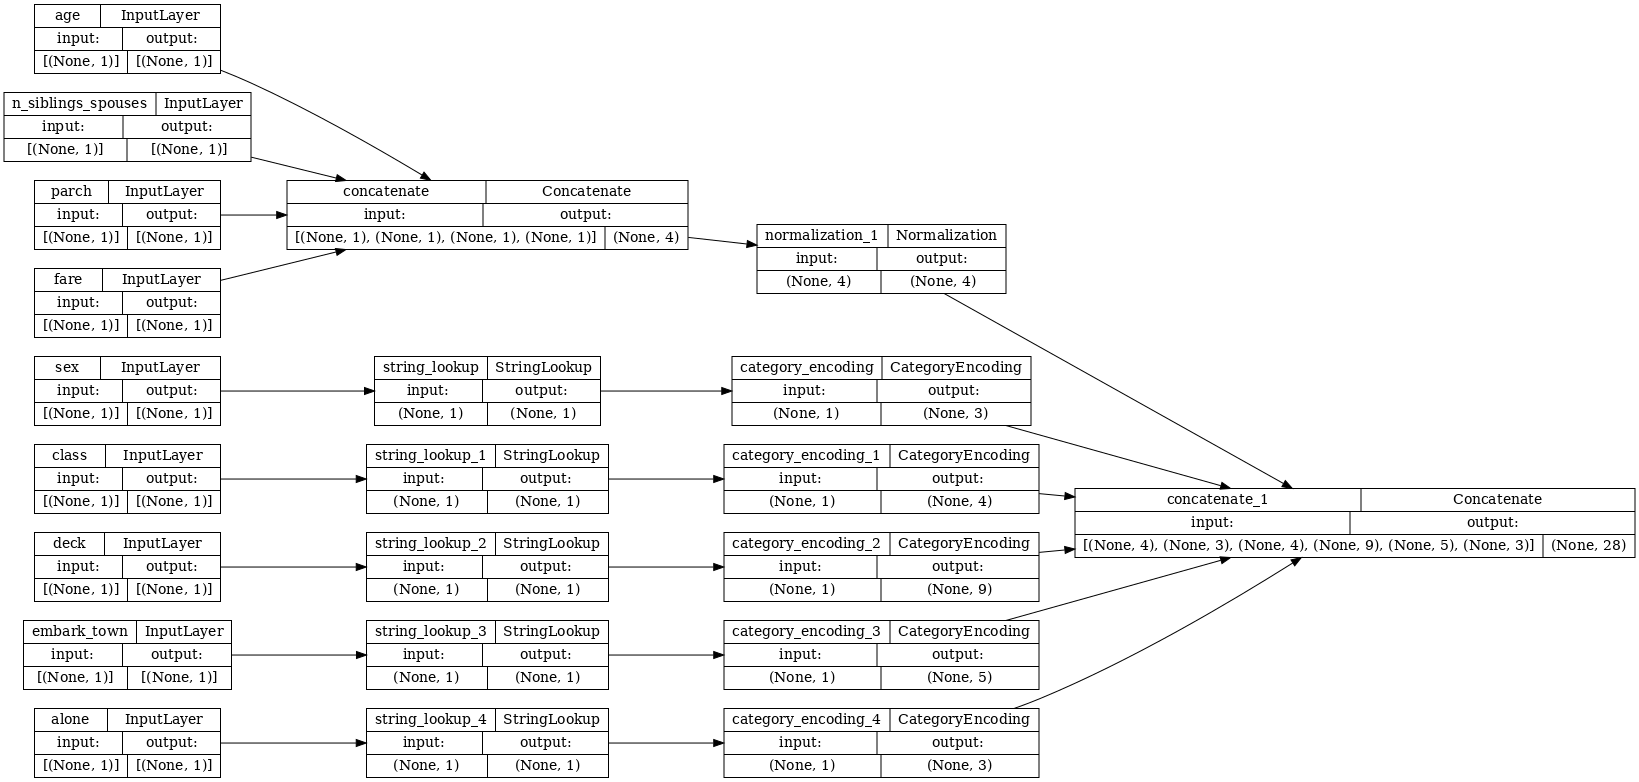

In [20]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

この`model`には、入力の前処理のみが含まれています。実行して、データに対して何が行われるかを確認できます。 Keras モデルは、Pandas <code>DataFrames</code>を自動的に変換しません。これは、1 つのテンソルに変換する必要があるのか、テンソルのディクショナリに変換する必要があるのかが明確でないためです。ここでは、テンソルのディクショナリに変換します。

In [21]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

最初のトレーニングサンプルをスライスしてこの前処理モデルに渡すと、数値特徴と文字列のワンホットがすべて連結されていることがわかります。

In [22]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[-0.61 ,  0.395, -0.479, -0.497,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  1.   ,  0.   ]], dtype=float32)>

次に、この上にモデルを構築します。

In [23]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

モデルをトレーニングする際に、特徴のディクショナリを`x`、ラベルを`y`として渡します。

In [24]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10


 1/20 [>.............................] - ETA: 20s - loss: 0.7569

13/20 [==================>...........] - ETA: 0s - loss: 0.6343 

20/20 [==============================] - 1s 4ms/step - loss: 0.6127


Epoch 2/10


 1/20 [>.............................] - ETA: 0s - loss: 0.5930

14/20 [====================>.........] - ETA: 0s - loss: 0.5373

20/20 [==============================] - 0s 4ms/step - loss: 0.5131


Epoch 3/10


 1/20 [>.............................] - ETA: 0s - loss: 0.4365

14/20 [====================>.........] - ETA: 0s - loss: 0.4834

20/20 [==============================] - 0s 4ms/step - loss: 0.4796


Epoch 4/10


 1/20 [>.............................] - ETA: 0s - loss: 0.4290

14/20 [====================>.........] - ETA: 0s - loss: 0.4432

20/20 [==============================] - 0s 4ms/step - loss: 0.4598


Epoch 5/10


 1/20 [>.............................] - ETA: 0s - loss: 0.4617

14/20 [====================>.........] - ETA: 0s - loss: 0.4513

20/20 [==============================] - 0s 4ms/step - loss: 0.4468


Epoch 6/10


 1/20 [>.............................] - ETA: 0s - loss: 0.3015

13/20 [==================>...........] - ETA: 0s - loss: 0.4450

20/20 [==============================] - 0s 4ms/step - loss: 0.4389


Epoch 7/10


 1/20 [>.............................] - ETA: 0s - loss: 0.3833

14/20 [====================>.........] - ETA: 0s - loss: 0.4150

20/20 [==============================] - 0s 4ms/step - loss: 0.4312


Epoch 8/10


 1/20 [>.............................] - ETA: 0s - loss: 0.4546

14/20 [====================>.........] - ETA: 0s - loss: 0.4190

20/20 [==============================] - 0s 4ms/step - loss: 0.4279


Epoch 9/10


 1/20 [>.............................] - ETA: 0s - loss: 0.5163

14/20 [====================>.........] - ETA: 0s - loss: 0.4223

20/20 [==============================] - 0s 4ms/step - loss: 0.4245


Epoch 10/10


 1/20 [>.............................] - ETA: 0s - loss: 0.3948

14/20 [====================>.........] - ETA: 0s - loss: 0.4180

20/20 [==============================] - 0s 4ms/step - loss: 0.4237


前処理はモデルの一部であるため、モデルを保存して別の場所で再読み込みしても、同じ結果を得ることができます。

In [25]:
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test/assets


In [26]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[-1.903]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.903]], shape=(1, 1), dtype=float32)


## tf.data を使用する


前のセクションでは、モデルのトレーニングの際に、モデルに組み込まれているデータのシャッフルとバッチ処理に依存しました。

入力データパイプラインをさらに制御する必要がある場合、またはメモリに簡単に収まらないデータを使用する必要がある場合は、`tf.data`を使用します。

詳細については、<a><code>tf.data</code>: TensorFlow 入力パイプラインをビルドする</a>ガイドをご覧ください。

### インメモリデータ

`tf.data` を CSV データに適用する最初の例として、次のコードで前のセクションの特徴のディクショナリを手動でスライスします。各インデックスは、特徴ごとにそのインデックスを取得します。


In [27]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

実行して、最初のサンプルを出力します。

In [28]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

sex                : male
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : Third
deck               : unknown
embark_town        : Southampton
alone              : n


メモリデータローダーの最も基本的な`tf.data.Dataset`は、`Dataset.from_tensor_slices`コンストラクタです。これにより、TensorFlowで上記の`slices`関数の一般化されたバージョンを実装する`tf.data.Dataset`が返されます。

In [29]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

他の Python 反復可能と同様に、`tf.data.Dataset`を反復できます。

In [30]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

sex                : b'male'
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : b'Third'
deck               : b'unknown'
embark_town        : b'Southampton'
alone              : b'n'


`from_tensor_slices`関数は、ネストされたディクショナリーまたはタプルの任意の構造を処理できます。次のコードは、`(features_dict, labels)`ペアのデータセットを作成します。

In [31]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

この`Dataset`を使用してモデルをトレーニングするには、少なくとも`shuffle`と`batch`のデータが必要です。

In [32]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

`features`と`labels`を`Model.fit`に渡す代わりに、データセットを渡します。

In [33]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5


 1/20 [>.............................] - ETA: 7s - loss: 0.4115

13/20 [==================>...........] - ETA: 0s - loss: 0.4472

20/20 [==============================] - 0s 4ms/step - loss: 0.4218


Epoch 2/5


 1/20 [>.............................] - ETA: 0s - loss: 0.4773

14/20 [====================>.........] - ETA: 0s - loss: 0.4132

20/20 [==============================] - 0s 4ms/step - loss: 0.4229


Epoch 3/5


 1/20 [>.............................] - ETA: 0s - loss: 0.5273

14/20 [====================>.........] - ETA: 0s - loss: 0.4138

20/20 [==============================] - 0s 4ms/step - loss: 0.4203


Epoch 4/5


 1/20 [>.............................] - ETA: 0s - loss: 0.4186

14/20 [====================>.........] - ETA: 0s - loss: 0.4247

20/20 [==============================] - 0s 4ms/step - loss: 0.4209


Epoch 5/5


 1/20 [>.............................] - ETA: 0s - loss: 0.4313

13/20 [==================>...........] - ETA: 0s - loss: 0.4085

20/20 [==============================] - 0s 4ms/step - loss: 0.4213


### 単一のファイルから

これまでのところ、このチュートリアルはインメモリデータを扱ってきました。`tf.data`は、データパイプラインを構築するための非常にスケーラブルなツールキットであり、CSV ファイルの読み込みを処理するためのいくつかの関数を提供します。 

In [34]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

 8192/30874 [======>.......................] - ETA: 0s

30874/30874 [==============================] - 0s 0us/step


次に、ファイルから CSV データを読み取り、`tf.data.Dataset`を作成します。

（完全なドキュメントについては、`tf.data.experimental.make_csv_dataset` を参照してください。)


In [35]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    titanic_file_path,
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='survived',
    num_epochs=1,
    ignore_errors=True,)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


この関数には以下のような多くの便利な機能が含まれているため、データを簡単に操作できます。

- 列ヘッダーをディクショナリキーとして使用する。
- それぞれの列の型を自動的に決定する。

注意: `tf.data.experimental.make_csv_dataset` で `num_epochs` 引数を設定してください。<br>そうしないと、`tf.data.Dataset` のデフォルトの動作は無限ループです。

In [36]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

sex                 : [b'male' b'male' b'male' b'male' b'male']
age                 : [29.  2.  9. 42. 32.]
n_siblings_spouses  : [1 4 4 1 0]
parch               : [0 1 2 0 0]
fare                : [66.6   39.688 31.388 27.    56.496]
class               : [b'First' b'Third' b'Third' b'Second' b'Third']
deck                : [b'C' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'n' b'n' b'n' b'n' b'y']

label               : [0 0 0 0 1]


注意: 上記のセルを 2 回実行すると、異なる結果が生成されます。`tf.data.experimental.make_csv_dataset` のデフォルト設定には、`shuffle_buffer_size=1000` が含まれます。これは、この小さなデータセットには十分ですが、実際のデータセットには適切ではない場合があります。

また、その場でデータを解凍することもできます。 これは、[都市州間高速道路交通データセット](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)を含む gzip 圧縮された CSV ファイルです。

![交通渋滞](images/csv/traffic.jpg)

画像出典：[Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)


In [37]:
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')

  8192/405373 [..............................] - ETA: 0s

 81920/405373 [=====>........................] - ETA: 0s

303104/405373 [=====================>........] - ETA: 0s

405373/405373 [==============================] - 0s 0us/step


圧縮ファイルから直接読み取るように`compression_type`引数を設定します。

In [38]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

for batch, label in traffic_volume_csv_gz_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value[:5]}")
  print()
  print(f"{'label':20s}: {label[:5]}")

holiday             : [b'None' b'None' b'None' b'None' b'None']
temp                : [285.65 267.15 284.61 275.36 296.48]
rain_1h             : [0.25 0.   0.   0.   0.  ]
snow_1h             : [0. 0. 0. 0. 0.]
clouds_all          : [92 90  0 90  0]
weather_main        : [b'Rain' b'Clouds' b'Clear' b'Drizzle' b'Clear']
weather_description : [b'light rain' b'overcast clouds' b'Sky is Clear'
 b'light intensity drizzle' b'Sky is Clear']
date_time           : [b'2013-06-06 00:00:00' b'2013-02-12 21:00:00' b'2013-08-04 07:00:00'
 b'2013-05-04 18:00:00' b'2013-08-14 17:00:00']

label               : [ 655 2669 1132 4431 6136]


注意: `tf.data`パイプラインでこれらの日時文字列を解析する必要がある場合は、`tfa.text.parse_time`を使用できます。

### キャッシング

CSV データの解析にはオーバーヘッドがあります。小さなモデルの場合、これがトレーニングのボトルネックになる可能性があります。

ユースケースによっては、`Dataset.cache` または `tf.data.experimental.snapshot` を使用して、CSV データが最初のエポックでのみ解析されるようにすることをお勧めします。

`cache`メソッドと`snapshot`メソッドの主な違いは、`cache`ファイルは、それらを作成した TensorFlow プロセスでのみ使用できることですが、`snapshot`ファイルは他のプロセスで読み取ることができます。

たとえば、`traffic_volume_csv_gz_ds` を 20 回繰り返すと、キャッシュなしで最大15秒、キャッシュありで最大 2 秒かかります。

In [39]:
%%time
for i, (batch, label) in enumerate(traffic_volume_csv_gz_ds.repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

..

..

..

..

..

..

...

..

..

..

..

..

..

..

..

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

..

...

..

..

..

..

.
CPU times: user 15.6 s, sys: 4.14 s, total: 19.8 s
Wall time: 11.5 s


注意: `Dataset.cache` は、最初のエポックからのデータを保存し、順番に再生します。したがって、`cache` を使用すると、パイプラインの早い段階でシャッフルが無効になります。以下では、`Dataset.shuffle`は、`Dataset.cache` の後に追加されます。

In [40]:
%%time
caching = traffic_volume_csv_gz_ds.cache().shuffle(1000)

for i, (batch, label) in enumerate(caching.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

..................

...................

...................

...................

...................

.
CPU times: user 1.86 s, sys: 297 ms, total: 2.15 s
Wall time: 1.68 s


注意: `tf.data.experimental.snapshot` ファイルは、使用中のデータセットの*一時*ストレージ用です。これは、*長期保存用の形式*ではありません。このファイル形式は内部の詳細と見なされ、TensorFlow バージョン間で保証されません。

In [41]:
%%time
snapshot = tf.data.experimental.snapshot('titanic.tfsnap')
snapshotting = traffic_volume_csv_gz_ds.apply(snapshot).shuffle(1000)

for i, (batch, label) in enumerate(snapshotting.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

Instructions for updating:
Use `tf.data.Dataset.snapshot(...)`.


..............

..............

.................

.................

.................

................
CPU times: user 2.88 s, sys: 854 ms, total: 3.73 s
Wall time: 1.96 s


CSV ファイルの読み込みによってデータの読み込みが遅くなり、`Dataset.cache` と `tf.data.experimental.snapshot` がユースケースに不十分な場合は、データをより合理化された形式に再度エンコードすることを検討してください。

### 複数のファイル

このセクションのこれまでのすべての例は、`tf.data`なしで簡単に実行できます。 `tf.data`が単純化できるのは、ファイルの収集を処理するときだけです。

たとえば、[文字フォント画像](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images)データセットは、フォントごとに1つずつの CSV ファイルのコレクションとして配布されます。

![フォント](images/csv/fonts.jpg)

画像出典：<a href="https://pixabay.com/users/wilhei-883152/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Pixabay</a>、<a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Willi Heidelbach</a>

データセットをダウンロードし、そのファイルを確認します。

In [42]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.', cache_subdir='fonts',
    extract=True)

     8192/160313983 [..............................] - ETA: 0s

    81920/160313983 [..............................] - ETA: 3:03

   319488/160313983 [..............................] - ETA: 1:34

  1040384/160313983 [..............................] - ETA: 36s 

  2048000/160313983 [..............................] - ETA: 22s

  3751936/160313983 [..............................] - ETA: 14s

  6750208/160313983 [>.............................] - ETA: 8s 

  9805824/160313983 [>.............................] - ETA: 6s

 12918784/160313983 [=>............................] - ETA: 5s

 15998976/160313983 [=>............................] - ETA: 4s

 19079168/160313983 [==>...........................] - ETA: 4s

 22183936/160313983 [===>..........................] - ETA: 3s

 25280512/160313983 [===>..........................] - ETA: 3s

 28377088/160313983 [====>.........................] - ETA: 3s

 31457280/160313983 [====>.........................] - ETA: 3s

 34545664/160313983 [=====>........................] - ETA: 3s

 37650432/160313983 [======>.......................] - ETA: 2s

 40738816/160313983 [======>.......................] - ETA: 2s

 43819008/160313983 [=======>......................] - ETA: 2s

 46891008/160313983 [=======>......................] - ETA: 2s

 49946624/160313983 [========>.....................] - ETA: 2s

 53018624/160313983 [========>.....................] - ETA: 2s

 56107008/160313983 [=========>....................] - ETA: 2s

 59187200/160313983 [==========>...................] - ETA: 2s

 62275584/160313983 [==========>...................] - ETA: 2s

 65298432/160313983 [===========>..................] - ETA: 1s

 68304896/160313983 [===========>..................] - ETA: 1s

 71385088/160313983 [============>.................] - ETA: 1s

 74465280/160313983 [============>.................] - ETA: 1s

 77545472/160313983 [=============>................] - ETA: 1s

 80633856/160313983 [==============>...............] - ETA: 1s

 83714048/160313983 [==============>...............] - ETA: 1s

 86777856/160313983 [===============>..............] - ETA: 1s

 89890816/160313983 [===============>..............] - ETA: 1s

 93200384/160313983 [================>.............] - ETA: 1s

 96305152/160313983 [=================>............] - ETA: 1s

 99598336/160313983 [=================>............] - ETA: 1s

102703104/160313983 [==================>...........] - ETA: 1s

106037248/160313983 [==================>...........] - ETA: 1s

109174784/160313983 [===================>..........] - ETA: 0s

112467968/160313983 [====================>.........] - ETA: 0s

115703808/160313983 [====================>.........] - ETA: 0s

118857728/160313983 [=====================>........] - ETA: 0s

122044416/160313983 [=====================>........] - ETA: 0s

125206528/160313983 [======================>.......] - ETA: 0s

128532480/160313983 [=======================>......] - ETA: 0s

131547136/160313983 [=======================>......] - ETA: 0s

134856704/160313983 [========================>.....] - ETA: 0s

137936896/160313983 [========================>.....] - ETA: 0s

141238272/160313983 [=========================>....] - ETA: 0s

144400384/160313983 [==========================>...] - ETA: 0s

147726336/160313983 [==========================>...] - ETA: 0s

150839296/160313983 [===========================>..] - ETA: 0s

154157056/160313983 [===========================>..] - ETA: 0s

157253632/160313983 [============================>.] - ETA: 0s

160313983/160313983 [==============================] - 3s 0us/step


In [43]:
import pathlib
font_csvs =  sorted(str(p) for p in pathlib.Path('fonts').glob("*.csv"))

font_csvs[:10]

['fonts/AGENCY.csv',
 'fonts/ARIAL.csv',
 'fonts/BAITI.csv',
 'fonts/BANKGOTHIC.csv',
 'fonts/BASKERVILLE.csv',
 'fonts/BAUHAUS.csv',
 'fonts/BELL.csv',
 'fonts/BERLIN.csv',
 'fonts/BERNARD.csv',
 'fonts/BITSTREAMVERA.csv']

In [44]:
len(font_csvs)

153

多数のファイルを処理する場合、glob スタイルの `file_pattern` を `tf.data.experimental.make_csv_dataset` 関数に渡すことができます。ファイルの順序は、反復ごとにシャッフルされます。

`num_parallel_reads`引数を使用して、並列に読み取り、共にインターリーブされるファイルの数を設定します。

In [45]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=10, num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000)

これらの CSV ファイルでは、画像が 1 行にフラット化されています。列名の形式は `r{row}c{column}` です。以下は最初のバッチです。

In [46]:
for features in fonts_ds.take(1):
  for i, (name, value) in enumerate(features.items()):
    if i>15:
      break
    print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'BASKERVILLE' b'CANDARA' b'IMPACT' b'BERNARD' b'VLADIMIR' b'MYANMAR'
 b'TAI' b'PHAGSPA' b'COURIER' b'PHAGSPA']
fontVariant         : [b'BASKERVILLE OLD FACE' b'CANDARA' b'IMPACT' b'BERNARD MT CONDENSED'
 b'VLADIMIR SCRIPT' b'MYANMAR TEXT' b'MICROSOFT TAI LE'
 b'MICROSOFT PHAGSPA' b'scanned' b'MICROSOFT PHAGSPA']
m_label             : [   48  8311  1089   733   218 43518   210  8227    51  8245]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [0 0 0 1 0 0 1 0 0 0]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [33 41 44 29 23 23 20 62  0 43]
m_left              : [22 22 22 37 28 24 29 24  0 24]
originalH           : [46 24 45  8 57 67 63 10 20 15]
originalW           : [29 14 28 28 61 64 49  6 15  7]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [  1 255   1   1   1   1   1 255   1 255]
r0c1                : [  1 2

...
[total: 412 features]


#### オプション：パッキングフィールド

以上のように、各ピクセルを別々の列で操作することは望ましくありません。このデータセットを使用する前に、必ずピクセルをイメージテンソルにパックしてください。

次に、列名を解析して各例の画像を作成するコードを示します。

In [47]:
import re

def make_images(features):
  image = [None]*400
  new_feats = {}

  for name, value in features.items():
    match = re.match('r(\d+)c(\d+)', name)
    if match:
      image[int(match.group(1))*20+int(match.group(2))] = value
    else:
      new_feats[name] = value

  image = tf.stack(image, axis=0)
  image = tf.reshape(image, [20, 20, -1])
  new_feats['image'] = image

  return new_feats

その関数をデータセット内の各バッチに適用します。

In [48]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
  break

結果の画像をプロットします。

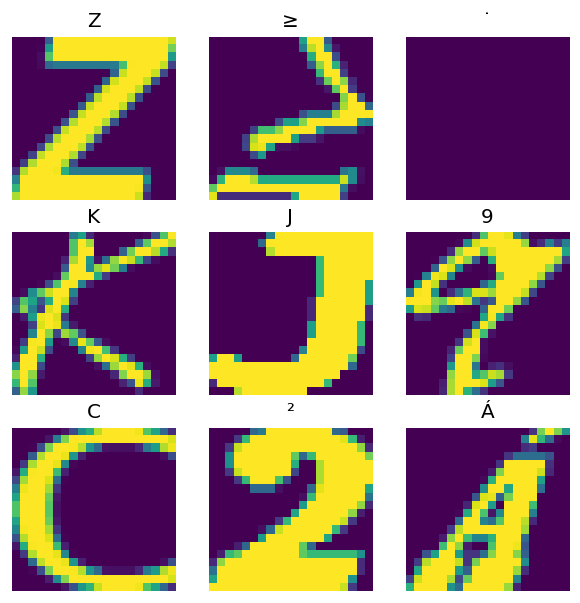

In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(features['image'][..., n])
  plt.title(chr(features['m_label'][n]))
  plt.axis('off')

## 下位レベルの関数

このチュートリアルでは、CSV データを読み取るための最高レベルのユーティリティに焦点を当ててきました。ユースケースが基本的なパターンに適合しない場合に上級ユーザーに役立つ API が他の 2 つあります。

- `tf.io.decode_csv`: テキストの行を CSV 列テンソルのリストに解析するための関数。
- `tf.data.experimental.CsvDataset`: 下位レベルの CSV データセットコンストラクタ。

このセクションでは、`tf.data.experimental.make_csv_dataset` により提供される機能を再作成して、この低レベルの機能をどのように使用できるかを示します。


### `tf.io.decode_csv`

この関数は、文字列または文字列のリストを列のリストにデコードします。

`tf.data.experimental.make_csv_dataset` とは異なり、この関数は列のデータ型を推測しようとしません。列ごとの正しい型の値を含む `record_defaults` のリストを提供することにより、列の型を指定します。

次のように <code>tf.io.decode_csv</code> を使用してタイタニックデータを<strong>文字列として</strong>読み取ります。

In [50]:
text = pathlib.Path(titanic_file_path).read_text()
lines = text.split('\n')[1:-1]

all_strings = [str()]*10
all_strings

['', '', '', '', '', '', '', '', '', '']

In [51]:
features = tf.io.decode_csv(lines, record_defaults=all_strings) 

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


それらを実際のタイプで解析するには、対応する型の`record_defaults`のリストを作成します。 

In [52]:
print(lines[0])

0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [53]:
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]
titanic_types

[0, '', 0.0, 0, 0, 0.0, '', '', '', '']

In [54]:
features = tf.io.decode_csv(lines, record_defaults=titanic_types) 

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

type: int32, shape: (627,)
type: string, shape: (627,)
type: float32, shape: (627,)
type: int32, shape: (627,)
type: int32, shape: (627,)
type: float32, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


注意: CSV テキストの個々の行を呼び出すよりも、行の大きなバッチで `tf.io.decode_csv` を呼び出す方が効率的です。

### `tf.data.experimental.CsvDataset`

`tf.data.experimental.CsvDataset` クラスは、`tf.data.experimental.make_csv_dataset` 関数の便利な機能（列ヘッダーの解析、列の型推論、自動シャッフル、ファイルのインターリーブ）なしで、最小限の CSV <code>Dataset</code> インターフェースを提供します。

このコンストラクタは、`tf.io.decode_csv` と同じ方法で `record_defaults` を使用します。


In [55]:
simple_titanic = tf.data.experimental.CsvDataset(titanic_file_path, record_defaults=titanic_types, header=True)

for example in simple_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


上記のコードは基本的に次と同等です。

In [56]:
def decode_titanic_line(line):
  return tf.io.decode_csv(line, titanic_types)

manual_titanic = (
    # Load the lines of text
    tf.data.TextLineDataset(titanic_file_path)
    # Skip the header row.
    .skip(1)
    # Decode the line.
    .map(decode_titanic_line)
)

for example in manual_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


#### 複数のファイル

`tf.data.experimental.CsvDataset` を使用してフォントデータセットを解析するには、最初に `record_defaults` の列の型を決定する必要があります。まず、1 つのファイルの最初の行を調べます。

In [57]:
font_line = pathlib.Path(font_csvs[0]).read_text().splitlines()[1]
print(font_line)

AGENCY,AGENCY FB,64258,0.400000,0,0.000000,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,255,255,1,1,1,93,255,255,255,176,146,146,146,146,146,146,146,146,216,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,141,141,141,182,255,255,255,172,141,141,141,115,1,1,1,1,163,255,255,255,255,255,255,255,255,255,255,255,255,255,255,209,1,1,1,1,163,255,255,255,6,6,6,96,255,255,255,74,6,6,6,5,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1

最初の 2 つのフィールドのみが文字列で、残りは int または float です。コンマを数えることで特徴の総数を取得できます。

In [58]:
num_font_features = font_line.count(',')+1
font_column_types = [str(), str()] + [float()]*(num_font_features-2)

`tf.data.experimental.CsvDataset` コンストラクタは、入力ファイルのリストを取得できますが、それらを順番に読み取ります。CSV のリストの最初のファイルは `AGENCY.csv` です。

In [59]:
font_csvs[0]

'fonts/AGENCY.csv'

したがって、ファイルのリストを `CsvDataset` に渡すと、`AGENCY.csv` のレコードが最初に読み取られます。

In [60]:
simple_font_ds = tf.data.experimental.CsvDataset(
    font_csvs, 
    record_defaults=font_column_types, 
    header=True)

In [61]:
for row in simple_font_ds.take(10):
  print(row[0].numpy())

b'AGENCY'
b'AGENCY'


b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'


複数のファイルをインターリーブするには、`Dataset.interleave`を使用します。

CSV ファイル名を含む初期データセットは次のとおりです。 

In [62]:
font_files = tf.data.Dataset.list_files("fonts/*.csv")

これにより、各エポックのファイル名がシャッフルされます。

In [63]:
print('Epoch 1:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')
print()

print('Epoch 2:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')

Epoch 1:
     b'fonts/SNAP.csv'
     b'fonts/CALIBRI.csv'
     b'fonts/IMPACT.csv'
     b'fonts/FELIX TITLING.csv'
     b'fonts/VINER.csv'
    ...

Epoch 2:


     b'fonts/BOOK.csv'
     b'fonts/IMPACT.csv'
     b'fonts/JAVANESE.csv'
     b'fonts/CURLZ.csv'
     b'fonts/TIMES.csv'
    ...


`interleave`メソッドは、親`Dataset`の各要素に対して子`Dataset`を作成する`map_func`を取ります。

ここでは、ファイルのデータセットの各要素から `tf.data.experimental.CsvDataset` を作成します。

In [64]:
def make_font_csv_ds(path):
  return tf.data.experimental.CsvDataset(
    path, 
    record_defaults=font_column_types, 
    header=True)

インターリーブによって返される `Dataset` は、子 `Dataset` の数を循環することによって要素を返します。以下でデータセットが `cycle_length=3` で 3 つのフォントファイルをどのように循環するかに注目してください。

In [65]:
font_rows = font_files.interleave(make_font_csv_ds,
                                  cycle_length=3)

In [66]:
fonts_dict = {'font_name':[], 'character':[]}

for row in font_rows.take(10):
  fonts_dict['font_name'].append(row[0].numpy().decode())
  fonts_dict['character'].append(chr(row[2].numpy()))

pd.DataFrame(fonts_dict)

/tmpfs/tmp/ipykernel_523702/998453860.py:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  fonts_dict['character'].append(chr(row[2].numpy()))


font_name character
0   BOOKMAN         ﬂ
1  INFORMAL         
2  PRISTINA         
3   BOOKMAN         ﬁ
4  INFORMAL         
5  PRISTINA         
6   BOOKMAN         
7  INFORMAL         
8  PRISTINA         ◊
9   BOOKMAN         

#### 性能


前述のとおり、文字列のバッチで実行する場合、`tf.io.decode_csv` の方が効率的です。

大きなバッチサイズを使用する場合は、これを利用して CSV の読み込みパフォーマンスを向上させることができます（ただし、最初に [caching](#caching) を試してください）。

組み込みローダー 20 では、2048 サンプルのバッチは約 17 秒かかります。 

In [67]:
BATCH_SIZE=2048
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=BATCH_SIZE, num_epochs=1,
    num_parallel_reads=100)

In [68]:
%%time
for i,batch in enumerate(fonts_ds.take(20)):
  print('.',end='')

print()

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


CPU times: user 50.3 s, sys: 4.49 s, total: 54.8 s
Wall time: 21.2 s


**テキスト行のバッチ**を`decode_csv`に渡すと、約 5 秒で高速に実行されます。

In [69]:
fonts_files = tf.data.Dataset.list_files("fonts/*.csv")
fonts_lines = fonts_files.interleave(
    lambda fname:tf.data.TextLineDataset(fname).skip(1), 
    cycle_length=100).batch(BATCH_SIZE)

fonts_fast = fonts_lines.map(lambda x: tf.io.decode_csv(x, record_defaults=font_column_types))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [70]:
%%time
for i,batch in enumerate(fonts_fast.take(20)):
  print('.',end='')

print()

....................


CPU times: user 4.24 s, sys: 51.5 ms, total: 4.29 s
Wall time: 721 ms


大きなバッチを使用して CSV パフォーマンスを向上させる別の例については、[過剰適合および過少学習チュートリアル](../keras/overfit_and_underfit.ipynb)を参照してください。

このようなアプローチは機能する可能性がありますが、`Dataset.cache` や `tf.data.experimental.snapshot` などの他のオプションやデータをより合理化された形式に再エンコードすることを検討してください。